In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
from torch.optim import AdamW

## LSTM 模型

In [2]:
WINDOW_SIZE = 24
BATCH_SIZE = 128
EPOCHS = 500
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv("train.csv")
df = df.drop(columns=["instant", "dteday", "mnth", "holiday", "atemp"])
features = df.drop(columns=["cnt"]).values
target = df["cnt"].values.reshape(-1, 1)

In [4]:
# 正規化
scaler_x = StandardScaler()
scaler_y = StandardScaler()
features = scaler_x.fit_transform(features)
target = scaler_y.fit_transform(target)

In [5]:
class BikeDataset(Dataset):
    def __init__(self, x, y, window_size):
        self.xs = []
        self.ys = []
        for i in range(len(x) - window_size):
            self.xs.append(x[i:i+window_size])
            self.ys.append(y[i+window_size])
        self.xs = np.array(self.xs)
        self.ys = np.array(self.ys)
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, idx):
        return torch.tensor(self.xs[idx], dtype=torch.float32), torch.tensor(self.ys[idx], dtype=torch.float32)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.1, shuffle=False)
train_loader = DataLoader(BikeDataset(x_train, y_train, WINDOW_SIZE), batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(BikeDataset(x_val, y_val, WINDOW_SIZE), batch_size=BATCH_SIZE)

In [7]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)  # BiLSTM -> hidden_size × 2
    """
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        
        out = self.dropout(out[:, -1, :])  # shape = (batch, hidden_size*2)
        return self.fc(out)
    """
    def forward(self, x):
        out, _ = self.lstm(x)                  # out shape: (B, T, H*2)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [8]:
model = LSTMModel(
    input_size=features.shape[1],
    hidden_size=128,
    num_layers=3,    
    dropout=0.5
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [9]:
model

LSTMModel(
  (lstm): LSTM(9, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# best!!
early_stopper = EarlyStopping(patience=20)
best_val_mse = float("inf")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb).squeeze()
        loss = criterion(pred, yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).squeeze()
            y_true.extend(yb.squeeze().cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    val_mse = mean_squared_error(y_true, y_pred)
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val MSE: {val_mse:.4f}")

    # EarlyStopping
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), "best_model_6.pth")
        print(f"💾 Saved best model (Val MSE: {best_val_mse:.4f})")

    early_stopper(val_mse)
    if early_stopper.early_stop:
        print(f"⛔ Early stopping at epoch {epoch+1}")
        break

Epoch 01 | Train Loss: 149.0334 | Val MSE: 0.8477
💾 Saved best model (Val MSE: 0.8477)
Epoch 02 | Train Loss: 94.3555 | Val MSE: 0.8220
💾 Saved best model (Val MSE: 0.8220)
Epoch 03 | Train Loss: 87.1352 | Val MSE: 0.8382
Epoch 04 | Train Loss: 82.2547 | Val MSE: 0.7831
💾 Saved best model (Val MSE: 0.7831)
Epoch 05 | Train Loss: 76.5785 | Val MSE: 0.6347
💾 Saved best model (Val MSE: 0.6347)
Epoch 06 | Train Loss: 65.5844 | Val MSE: 0.5113
💾 Saved best model (Val MSE: 0.5113)
Epoch 07 | Train Loss: 57.5211 | Val MSE: 0.4321
💾 Saved best model (Val MSE: 0.4321)
Epoch 08 | Train Loss: 49.1746 | Val MSE: 0.3644
💾 Saved best model (Val MSE: 0.3644)
Epoch 09 | Train Loss: 40.5131 | Val MSE: 0.2630
💾 Saved best model (Val MSE: 0.2630)
Epoch 10 | Train Loss: 35.8276 | Val MSE: 0.2265
💾 Saved best model (Val MSE: 0.2265)
Epoch 11 | Train Loss: 32.4736 | Val MSE: 0.2220
💾 Saved best model (Val MSE: 0.2220)
Epoch 12 | Train Loss: 29.7603 | Val MSE: 0.2122
💾 Saved best model (Val MSE: 0.2122)
Epoc

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

head_pad = train_df[train_df["dteday"] == "2012-10-31"].drop(columns=["instant", "dteday", "mnth", "holiday", "atemp", "cnt"])
head_pad = head_pad.reset_index(drop=True)

X_test = test_df.drop(columns=["instant", "dteday", "mnth", "holiday", "atemp"]).reset_index(drop=True)

X_padded = pd.concat([head_pad, X_test], ignore_index=True)

X_scaled = scaler_x.transform(X_padded.values)

INPUT_SIZE = X_scaled.shape[1]
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.5
WINDOW_SIZE = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load("best_model_11.pth", map_location=DEVICE))
model.eval()

preds = []
with torch.no_grad():
    for i in range(0, 480):
        window = X_scaled[i:i+WINDOW_SIZE]
        x_input = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        pred = model(x_input).cpu().numpy().flatten()[0]
        preds.append(pred)

# ====== 反標準化：還原 cnt =====
cnt_preds = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

cnt_preds = pd.DataFrame({
    "id": np.arange(480),
    "cnt": cnt_preds
})

hourly_cnt = cnt_preds["cnt"].values

daily_cnt = [np.sum(hourly_cnt[i:i+24]) for i in range(0, len(hourly_cnt), 24)]

submission = pd.DataFrame({
    "id": np.arange(20),
    "cnt": daily_cnt
})

submission.to_csv("submission_11.csv", index=False)

## 參數消融實驗

### SHAP  
因為不能用 Bi-LSTM 所以使用 LSTM model

/home/shuof/.conda/envs/lstm/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


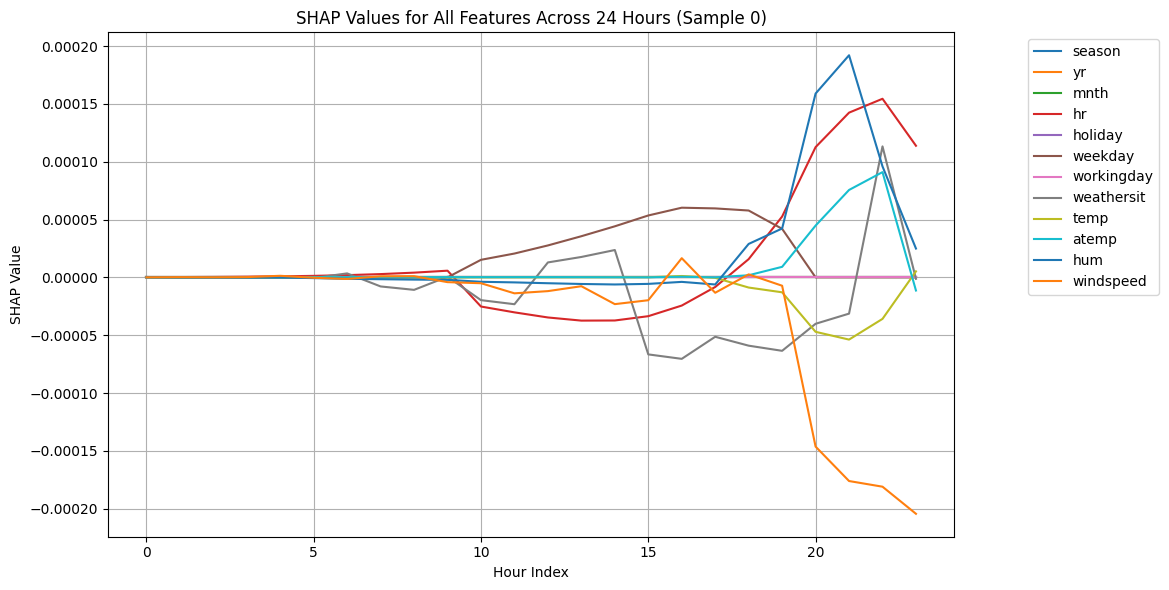

In [35]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch.nn as nn

df = pd.read_csv("train.csv")
df = df.drop(columns=["instant", "dteday"])
features = df.drop(columns=["cnt"]).values
target = df["cnt"].values.reshape(-1, 1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
features = scaler_x.fit_transform(features)
target = scaler_y.fit_transform(target)

WINDOW_SIZE = 24
DEVICE = "cpu"

class BikeDataset(Dataset):
    def __init__(self, x, y, window_size):
        self.xs = []
        self.ys = []
        for i in range(len(x) - window_size):
            self.xs.append(x[i:i+window_size])
            self.ys.append(y[i+window_size])
        self.xs = np.array(self.xs)
        self.ys = np.array(self.ys)
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, idx):
        return torch.tensor(self.xs[idx], dtype=torch.float32), torch.tensor(self.ys[idx], dtype=torch.float32)

# 驗證資料切分
split = int(0.9 * len(features))
x_val, y_val = features[split:], target[split:]
val_dataset = BikeDataset(x_val, y_val, WINDOW_SIZE)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === 2. LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.4):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=False # 無法反向
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

model = LSTMModel(
    input_size=features.shape[1],
    hidden_size=128,
    num_layers=3,    
    dropout=0.5
).to(DEVICE)
model.train()

X_samples = []
for xb, yb in val_loader:
    X_samples.append(xb)
    if len(X_samples) >= 3:
        break

X_all = torch.cat(X_samples, dim=0)  # (N, 24, F)
X_background = X_all[:10].to(DEVICE)
X_explain = X_all[10:13].to(DEVICE)

# === 5. SHAP 解釋 ===
explainer = shap.DeepExplainer(model, X_background)
shap_values = explainer.shap_values(X_explain)  # list of tensors

# === 6. 可視化結果 ===
# 以第0筆為例，繪製 feature 隨時間 (24h) 的 SHAP 值變化
shap_val = np.squeeze(shap_values[0])            # shape: (3, 24, features)
shap_avg = shap_val.mean(axis=0)  # shape: (24, num_features)

feature_names = df.drop(columns=["cnt"]).columns.tolist()

plt.figure(figsize=(12, 6))
for f in range(shap_val.shape[1]):
    plt.plot(range(shap_val.shape[0]), shap_val[:, f], label=feature_names[f])
plt.title("SHAP Values for All Features Across 24 Hours (Sample 0)")
plt.xlabel("Hour Index")
plt.ylabel("SHAP Value")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

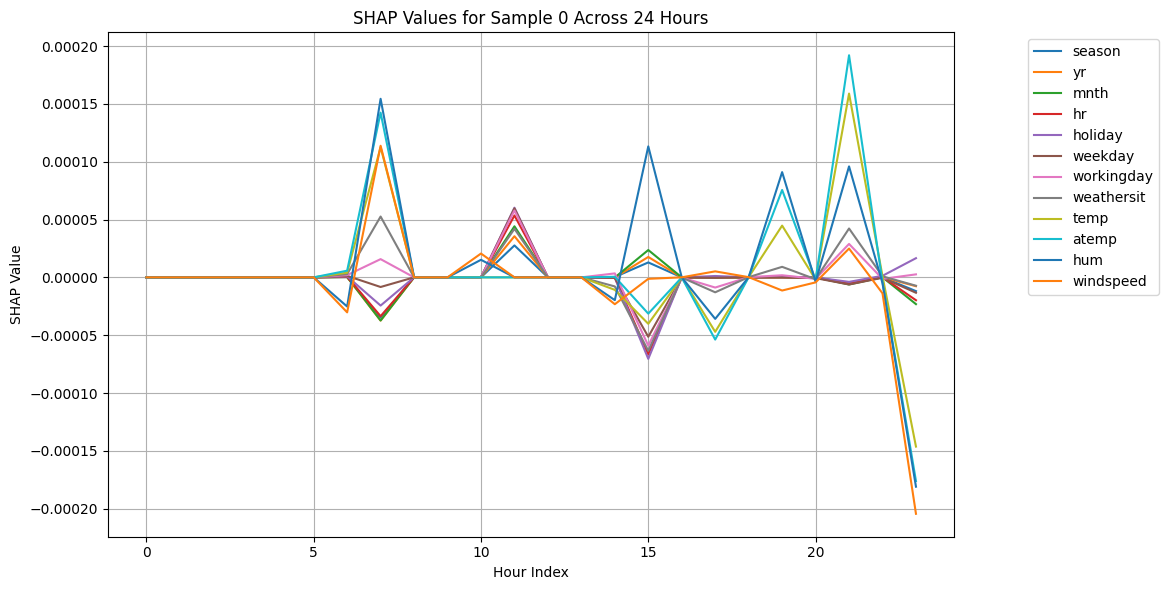

In [38]:
shap_val_all = np.transpose(np.squeeze(shap_values[0]), (1, 0)).reshape(1, 24, 12)
i = 0
plt.figure(figsize=(12, 6))
for f in range(shap_val_all.shape[2]):
    plt.plot(range(shap_val_all.shape[1]), shap_val_all[i, :, f], label=feature_names[f])
plt.title(f"SHAP Values for Sample {i} Across 24 Hours")
plt.xlabel("Hour Index")
plt.ylabel("SHAP Value")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

### 調個別參數訓練後看 MSE

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

# ========== 訓練參數 ==========
WINDOW_SIZE = 24
BATCH_SIZE = 64
EPOCHS = 100  # 測試用設定較少輪次
LR = 1e-3
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ========== Ablation Loop ==========
def run_ablation(feature_to_remove=None):

    df = pd.read_csv("train.csv")
    df = df.drop(columns=["instant", "dteday"])
    target = df["cnt"].values.reshape(-1, 1)

    feature_names = df.drop(columns=["cnt"]).columns.tolist()

    if feature_to_remove:
        df = df.drop(columns=[feature_to_remove])

    features = df.drop(columns=["cnt"]).values

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    features = scaler_x.fit_transform(features)
    target = scaler_y.fit_transform(target)

    x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.1, shuffle=False)
    train_loader = DataLoader(BikeDataset(x_train, y_train, WINDOW_SIZE), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(BikeDataset(x_val, y_val, WINDOW_SIZE), batch_size=BATCH_SIZE)

    model = LSTMModel(input_size=features.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).squeeze()
            loss = criterion(pred, yb.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).squeeze()
            loss = criterion(pred, yb.squeeze())
            val_loss += loss.item()

    return val_loss, feature_to_remove or "all_features"

print("🧪 正在執行 Feature Ablation 測試...\n")
results = []

# baseline
base_mse, _ = run_ablation()
results.append(("all_features", base_mse))

# 移除特徵
df_all = pd.read_csv("train.csv")
base_features = df_all.drop(columns=["instant", "dteday", "cnt"]).columns.tolist()

for feat in base_features:
    mse, name = run_ablation(feature_to_remove=feat)
    results.append((name, mse))

results = sorted(results, key=lambda x: x[1])
print("\n📊 Feature Importance (Ablation by MSE Increase):\n")
print(f"{'Feature':<15} | {'Val MSE':<10} | ΔMSE")
print("-" * 40)
for name, mse in results:
    delta = mse - base_mse
    print(f"{name:<15} | {mse:<10.4f} | {delta:+.4f}")

🧪 正在執行 Feature Ablation 測試...


📊 Feature Importance (Ablation by MSE Increase):

Feature         | Val MSE    | ΔMSE
----------------------------------------
workingday      | 2.5579     | -0.9052
windspeed       | 2.9956     | -0.4675
mnth            | 3.0873     | -0.3758
atemp           | 3.1467     | -0.3164
temp            | 3.1719     | -0.2912
hum             | 3.3650     | -0.0981
all_features    | 3.4631     | +0.0000
holiday         | 3.5259     | +0.0628
season          | 3.9891     | +0.5260
weekday         | 4.1540     | +0.6909
weathersit      | 4.7551     | +1.2920
hr              | 6.0174     | +2.5542
yr              | 16.0623    | +12.5992
